# Optosynth

... is it _really_ synthetic?! :-)

In [1]:
#! pip install --upgrade Pillow
#import PIL
#print(PIL.__version__)

In [2]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, 'sources'))
sys.path.insert(0, sources_path)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pprint import pprint

from specs import *
from optosynth import Optosynth

device = torch.device("cpu")
dtype = torch.float32

## Paths

In [3]:
optosynth_data_path = '/home/jupyter/external_disk/OPTO_DATA'
output_path = '/home/jupyter/external_disk/Optosynth_output'
output_prefix = 'test_data_25neurons'

if not os.path.exists(output_path):
    os.mkdir(output_path)

## (Optional) Download pre-processed Allen Brain data

In [4]:
if not os.path.exists(optosynth_data_path):
    os.mkdir(optosynth_data_path)
assert os.path.exists(optosynth_data_path)
#data_bucket = 'gs://mb_optosynth_data'
data_bucket = 'gs://ld-data-bucket'

In [ ]:
%%bash -s "$data_bucket" "$optosynth_data_path"
mkdir -p $2
gsutil -m cp -r $1/* $2

## Load summary of available sweeps

In [5]:
# summary of sweeps
ephys_summary_df = pd.read_csv(
    os.path.join(optosynth_data_path, 'processed_electrophysiology_summary.csv'), index_col=0)
ephys_summary_df.head()

,cell_id,sweep_index,stim_amp,n_spikes
0,480116737,0,-110.000000,0
1,480116737,1,-70.000000,0
2,480116737,2,-50.000000,0
3,480116737,3,-30.000002,0
4,480116737,4,10.000000,0


## Optosynth Specs

In [6]:
opto_specs = OptosynthSpecs(
    width=512,
    height=180,
    sampling_rate=500,
    duration_per_segment=2.0,
    scale_factor=0.75,
    n_neurons=25,
    min_neuron_fluorescence_scale_factor=0.1,
    max_neuron_fluorescence_scale_factor=1.0,
    stim_amp_range_list=[
        (50, 75),
        (125, 150),
        (175, 200)])

   # stim_amp_range_list=[
   #     (25, 50),
   #     (50, 75),
   #     (75, 100),
   #     (100, 125),
   #     (125, 150),
   #     (150, 175),
   #     (175, 200)])

neuron_specs = SyntheticNeuronSpecs(
    dendritic_backprop_velocity=5e4,
    dendritic_backprop_decay_lengthscale=50,
    min_reporter_density=1,
    max_reporter_density=10,
    reporter_density_var_lengthscale=1,
    n_integ_points=5)

bg_specs = BackgroundFluorescenceSpecs(
    dynamic_n_components=20,
    dynamic_x_lengthscale=10,
    dynamic_y_lengthscale=100,
    dynamic_fluorophore_density_scale=0.5,
    dynamic_temporal_frequency=100,
    static_x_lengthscale=5,
    static_y_lengthscale=5,
    static_min_total_fluorophore_density=0.0,
    static_max_total_fluorophore_density=0.1)    

v2f_specs = VoltageToFluorescenceSpecs(
    beta=0.01,
    v1=-100,
    f1=0.4,
    v2=50,
    f2=1.0)

cam_specs = CameraSpecs(
    dc_offset=500,
    gaussian_noise_std=10.,
    psf_lengthscale=1.,
    readout_per_photon=2.2,
    photon_per_fluorophore=50.)

## Generate

In [7]:
synth = Optosynth(
    opto_specs=opto_specs,
    neuron_specs=neuron_specs,
    bg_specs=bg_specs,
    v2f_specs=v2f_specs,
    cam_specs=cam_specs,
    ephys_summary_df=ephys_summary_df,
    optosynth_data_path=optosynth_data_path,
    device=device,
    dtype=dtype)

Randomly choosing 25 from 391 usable neurons ...
Loading morphology and electrophysiology data ...



Instantiating the background pattern generator ...
Instantiating the camera ...
Generating ground truth masks ...
Generating synthetic data for segment 1 / 3 ...



Generating synthetic data for segment 2 / 3 ...



Generating synthetic data for segment 3 / 3 ...



Generating clean and noisy camera readout for segment 1 / 3 ...



Generating clean and noisy camera readout for segment 2 / 3 ...



Generating clean and noisy camera readout for segment 3 / 3 ...


## Save

In [8]:
synth.save(os.path.join(output_path, output_prefix))

## Explore

In [9]:
for _, _, file in os.walk(os.path.join(output_path, output_prefix)):
    pprint(file)

['soma_coords_n2.npy',
 'noisy_movie_tyx.npy',
 'clean_movie_tyx.npy',
 'masks_nyx.npy',
 'background_tyx.npy',
 'clean_fluorescence_tyx.npy',
 'neuron_mean_fluorescence_nt.npy']


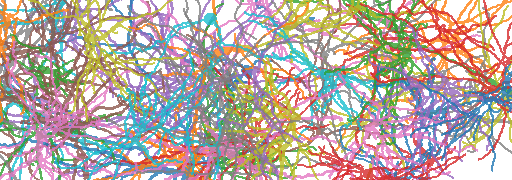

In [10]:
from PIL import Image, ImageOps 

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
combined_masks = Image.new('RGBA', size=(opto_specs.width, opto_specs.height))

for i_neuron in range(opto_specs.n_neurons):
    c_mask = Image.fromarray(synth.masks_nyx[i_neuron, ...])
    c_mask = ImageOps.colorize(
        c_mask.convert('L'),
        black='black',
        white=colors[i_neuron % len(colors)])
    c_mask = c_mask.convert('RGBA')
    c_pixels = c_mask.load()
    for x in range(opto_specs.width):
        for y in range(opto_specs.height):
            if c_pixels[x, y] == (0, 0, 0, 255):
                c_pixels[x, y] = (0, 0, 0, 0)
            else:
                c_pixels[x, y] = c_pixels[x, y][:3] + (200,)
    combined_masks.alpha_composite(c_mask)
combined_masks

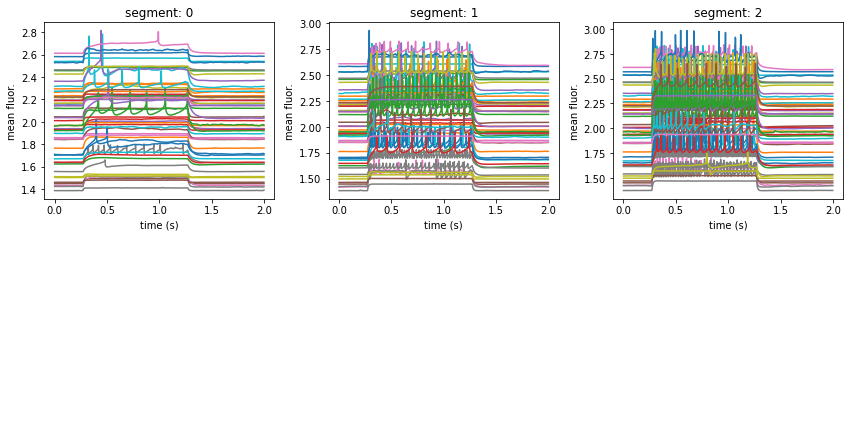

In [11]:
n_segments_per_row = 3
nrows = synth.n_segments // n_segments_per_row + 1
ncols = n_segments_per_row
fig, axs = plt.subplots(nrows, ncols, figsize=(n_segments_per_row * 4, 3 * nrows))
axs = np.asarray(axs).flatten()
for i_segment in range(synth.n_segments):
    ax = axs[i_segment]
    for i_neuron in range(opto_specs.n_neurons):
        ax.plot(
            synth.time_per_segment,
            synth.neuron_mean_fluorescence_nt_list[i_segment][i_neuron, :])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('mean fluor.')
        ax.set_title(f'segment: {i_segment}')
for i_ax in range(synth.n_segments, nrows * ncols):
    ax = axs[i_ax]
    ax.axis('off')
fig.tight_layout()

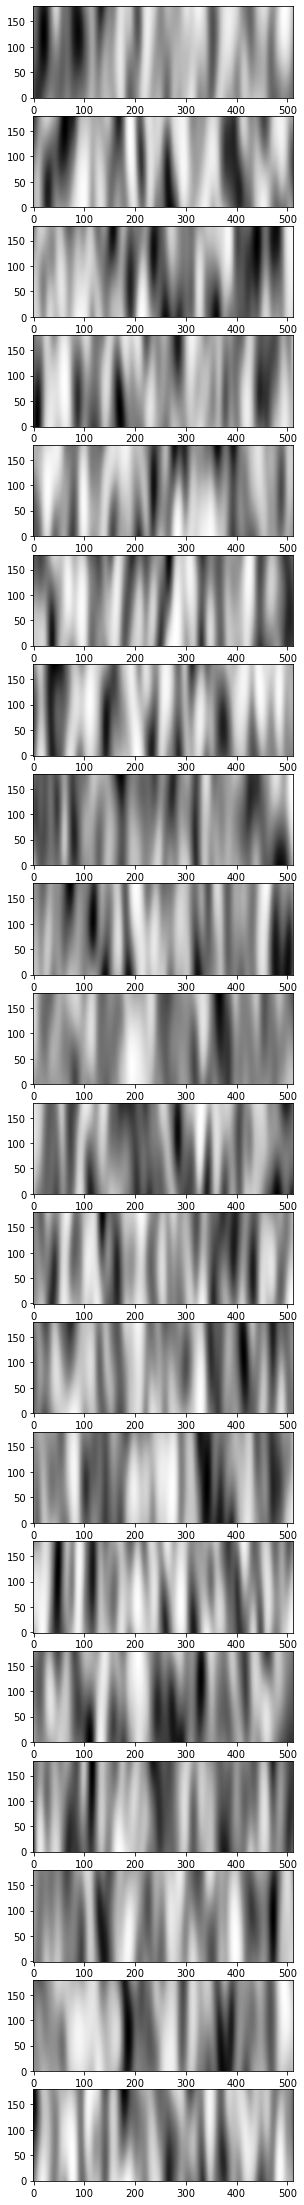

In [12]:
# dynamic background components
fig, axs = plt.subplots(nrows=bg_specs.dynamic_n_components, figsize=(5, 2 * bg_specs.dynamic_n_components))
axs = np.asarray(axs)
for i_bg in range(bg_specs.dynamic_n_components):
    axs[i_bg].imshow(synth.bg_gen.dynamic_bg_nyx[i_bg, ...], origin='lower', cmap=plt.cm.Greys_r)

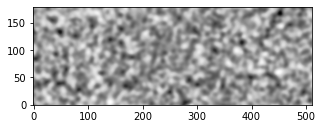

In [13]:
# static background
fig = plt.figure(figsize=(5, 2))
ax = plt.gca()
ax.imshow(synth.bg_gen.static_bg_yx, origin='lower', cmap=plt.cm.Greys_r)

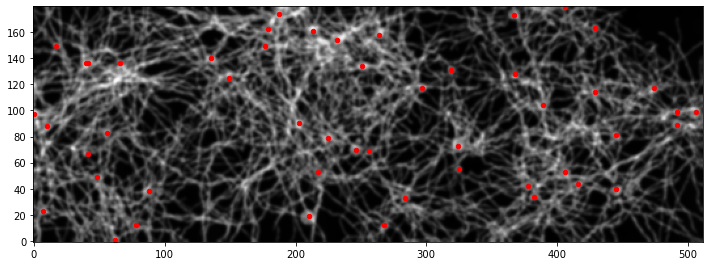

In [14]:
# clean movie (first frame of the first segment)
fig = plt.figure(figsize=(12, 5))
plt.imshow(
    synth.clean_movie_tyx_list[0][0, ...],
    cmap=plt.cm.Greys_r,
    origin='lower')
plt.scatter(synth.xs_n, synth.ys_n, color='red', s=20)

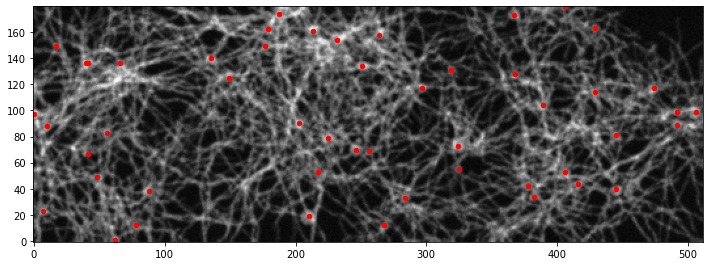

In [15]:
# noisy movie (first frame of the first segment)
fig = plt.figure(figsize=(12, 5))
plt.imshow(
    synth.noisy_movie_tyx_list[0][0, ...],
    cmap=plt.cm.Greys_r,
    origin='lower')
plt.scatter(synth.xs_n, synth.ys_n, color='red', s=20)

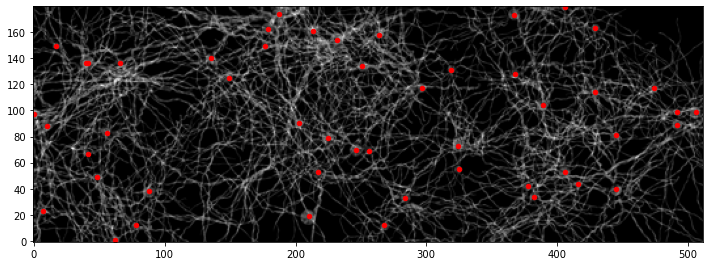

In [16]:
# total neuron fluorescence (first frame of the first segment)
fig = plt.figure(figsize=(12, 5))
plt.imshow(
    synth.neuron_fluorescence_tyx_list[0][0, ...],
    cmap=plt.cm.Greys_r,
    origin='lower')
plt.scatter(synth.xs_n, synth.ys_n, color='red', s=20)